In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import time
from scipy.spatial.distance import mahalanobis,euclidean
from sklearn import metrics
from scipy.spatial.distance import mahalanobis

# Load data

In [2]:
batch_num = 1
hidden_num = 5
step_num = 100
elem_num = 34
init_wins = 200

names = [str(x) for x in range(elem_num)] +["label"]
smtp = pd.read_csv("C:/Users/Bin/Desktop/Thesis/dataset/smtp.csv",names=names,skiprows=step_num*init_wins)
wins = smtp.shape[0]//step_num
test_set = smtp.iloc[:wins*batch_num*step_num,:-1]
labels =smtp.iloc[:wins*batch_num*step_num,-1]

ts = test_set.as_matrix().reshape(wins,batch_num,step_num,elem_num)
test_set_list = [ts[a] for a in range(wins)]

In [3]:
labels[labels!="normal"] = "anomaly"

In [4]:
del smtp
del test_set

In [5]:
# figure out anomaly windows
buffer = [labels[i*step_num:(i+1)*step_num] for i in range(0,labels.size//step_num)]
anomaly_index = []
count = 0
for buf in buffer:
    if "anomaly" in buf.tolist():
        anomaly_index.append(count)
    else:
        pass
    count +=1
print(anomaly_index)

expert = ["normal"]*wins
for x in anomaly_index:
    expert[x] = "anomaly"

[47, 60, 81, 118, 119, 120, 236, 261, 299, 319, 320, 321, 360, 400, 422, 484, 503, 566, 567, 568, 569, 571, 589, 590, 591, 597, 659, 699, 700, 701, 740, 741]


# Load Model

In [94]:
modelpath_root ="C:/Users/Bin/Desktop/Thesis/models/smtp_multivariate/"
modelmeta_p = modelpath_root + "_1_5_100_para.ckpt.meta"

sess = tf.Session()
saver = tf.train.import_meta_graph(modelmeta_p) # load trained gragh, but without the trained parameters
saver.restore(sess,tf.train.latest_checkpoint(modelpath_root))
graph = tf.get_default_graph()

p_input = graph.get_tensor_by_name("p_input:0")
p_inputs = [tf.squeeze(t, [1]) for t in tf.split(p_input, step_num, 1)] 
p_is_training = graph.get_tensor_by_name("is_training_:0")

input_= tf.transpose(tf.stack(p_inputs), [1, 0, 2])    
output_ = graph.get_tensor_by_name("decoder/output_:0")

tensor_mu = graph.get_tensor_by_name("mu:0")
tensor_sigma = graph.get_tensor_by_name("sigma:0")
tensor_threshold = graph.get_tensor_by_name("threshold:0")

loss_ = graph.get_tensor_by_name("decoder/loss:0")
train_ = graph.get_operation_by_name("cond/train_")

mu = sess.run(tensor_mu)
sigma = sess.run(tensor_sigma)
threshold = sess.run(tensor_threshold)

INFO:tensorflow:Restoring parameters from C:/Users/Bin/Desktop/Thesis/models/smtp_multivariate/_1_5_100_para.ckpt


In [29]:
print(mu.shape,sigma.shape,threshold)

(34,) (34, 34) 0.069146


# Online Phase (With expert)

In [27]:
def local_preprocessing(batchdata):
    # input batchdata with shape : [batch_num, step_num, elem_num]
    # minmax scaler on window level
    df = pd.DataFrame()
    
    for window in batchdata:
        
        scaler = MinMaxScaler()
        scaler.fit(window)
        new_win = scaler.transform(window)
        df = pd.concat((df, pd.DataFrame(new_win)),axis=0) if df.size!=0 else pd.DataFrame(new_win)
    return df.as_matrix().reshape(batchdata.shape)

    

In [11]:
def scoring(err,mu,sigma):
    
    scores = []
    for e in err:
        scores.append(mahalanobis(e,mu,sigma))

    return scores

In [27]:
def update_parameter(errBuffer,mu,sigma,eta,threshold,score,label):       
        tmp_errBuffer = errBuffer[-3:] if len(errBuffer)>3 else errBuffer
        err_vec_array = np.array(tmp_errBuffer)
        # for univariate  data
        __mu = np.mean(err_vec_array.ravel())
        mu = mu*eta + __mu*(1-eta)

        __sigma =np.var(err_vec_array.ravel())
        sigma = __sigma
        
        __thresold = scores.min()
        f = 0
        for t in range(int(scores.min()*100),int(scores.max()*100),5):
            fbeta,_, _ = evaluate(t/100,score,label)
            __thresold = t/100 if fbeta>f else __thresold
            
        threshold = threshold*eta + __thresold*(1-eta)
        return mu,sigma,threshold

In [9]:
def get_musigma(err_nbuf,mu,sigma):       
    
        err_vec_array = np.array(err_nbuf)
        # for multivariate  data
        mu = np.mean(err_vec_array,axis=0)
        sigma = np.cov(err_vec_array.T)
        return mu, sigma

In [10]:
def get_threshold(normal_score, abnormal_score):
        upper = np.median(np.array(abnormal_score))
        lower = np.median(np.array(normal_score)) 
        scala = 20
        delta = (upper-lower) / scala
        candidate = lower
        threshold = 0
        result = 0

        def evaluate(threshold,normal_score,abnormal_score):

            beta = 0.5
            tp = np.array(abnormal_score)[np.array(abnormal_score)>threshold].size
            fp = len(abnormal_score)-tp
            fn = np.array(normal_score)[np.array(normal_score)>threshold].size
            tn = len(normal_score)- fn

            if tp == 0: return 0

            P = tp/(tp+fp)
            R = tp/(tp+fn)
            fbeta= (1+beta*beta)*P*R/(beta*beta*P+R)
            return fbeta 

        for _ in range(scala):
            r = evaluate(candidate,normal_score,abnormal_score)
            if r > result:
                result = r 
                threshold = candidate
            candidate += delta 
        return threshold

In [12]:
def plot_roc(fpr,tpr,auc):
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' %auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
TP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
TP
TP
TP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
FP
F

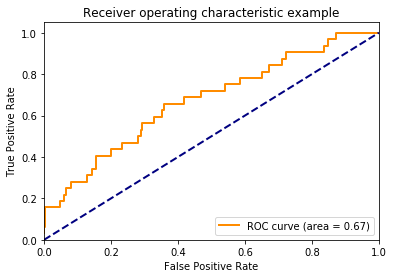

In [95]:
count = 0
n_buf = []
a_buf = []

y = []
output=[]
box = []
err_nbuf = []
err_abuf = []
all_scores = []

for l in labels:
    if l == "normal":
        y +=[0]
    else: 
        y +=[1]
for data in test_set_list:
    
        prediction = []
        df = local_preprocessing(data)
        (input_n, output_n) = sess.run([input_, output_], {p_input: df, p_is_training: False})

        err = abs(input_n-output_n).reshape(-1,elem_num)
        
        box.append(err.reshape(-1,))
        
        scores = scoring(err,mu,sigma)
        scores = pd.Series(scores)
        
        all_scores.append(scores)
#        output +=  [np.array(heapq.nlargest(10,scores)).mean()]
        output += [scores.max()]
        pred = [scores[b*step_num:(b+1)*step_num] for b in range(batch_num)]
        label = [expert[count*batch_num+b]for b in range(batch_num)]
        e = [err.reshape(-1,elem_num)]
        for index,value in enumerate(pred):
            if value[value>threshold].size>=5: 
                if label[index] == "anomaly":
                    print("TP")                 
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    print("FP")
                    err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    n_buf.append(df[index])
            else:               
                if label[index] == "anomaly":             
                    print("FN")
                    a_buf.append(df[index])
                    err_abuf.append(e[index])
                    #err_abuf = err_abuf + e[index] if len(err_abuf) != 0 else e[index]
                else:
                    err_nbuf.append(e[index])
                    #err_nbuf = err_nbuf + e[index] if len(err_nbuf) != 0 else e[index]
                    print("TN")
        count +=1
        

        
        if len(n_buf)>=1000 and len(a_buf)>=20:
            print("retrain...")
            loss_list_all=[]

            datalist = np.array(n_buf[:6]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_n = np.array(n_buf[6:]).reshape(-1,batch_num,step_num,elem_num)
            validation_list_a = np.array(a_buf).reshape(-1,batch_num,step_num,elem_num)
            
            for i in range(50):
                
                loss_list=[]
                for data in datalist:
                    (loss, _) = sess.run([loss_, train_], {p_input: data,p_is_training : True})
                    loss_list.append(loss)
                #print('Retrain-iter %d:' % (i + 1), np.array(loss_list).mean())
                loss_list_all.append( np.array(loss_list).mean()) 
            

            err_nbuf_tmp = np.array(err_nbuf).reshape(-1,elem_num)
            mu,sigma = get_musigma(err_nbuf_tmp,mu,sigma)

            normal_score = []
            abnormal_score = []
            
            for val in validation_list_n:
                (ein,aus) = sess.run([input_,output_], {p_input: val,p_is_training :False})
                
                err = abs(ein-aus).reshape(-1,elem_num)
        
                normal_score +=scoring(err,mu,sigma)
            
            for val_a in validation_list_a:
                (ein,aus) = sess.run([input_,output_], {p_input: val_a,p_is_training :False})
                
                err = abs(ein-aus).reshape(-1,elem_num)
        
                abnormal_score +=scoring(err,mu,sigma)
            
            threshold = get_threshold(normal_score, abnormal_score)
        
            print("Parameters updated!")
            pd.Series(loss_list_all).plot(title="Loss")
            n_buf = []
            a_buf = []
            err_buf = []
                
fpr, tpr, thresholds = metrics.roc_curve(expert, output, pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

plt.show()

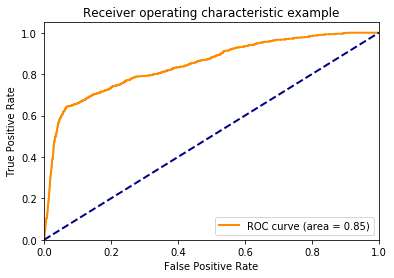

In [97]:
#with retraining
foo = pd.Series(np.array(all_scores).ravel())
fpr, tpr, thresholds = metrics.roc_curve(labels[1:], foo[1:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)

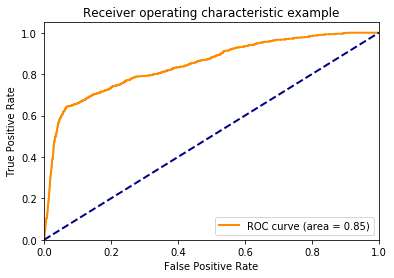

In [91]:
#without retraining
foo = pd.Series(np.array(all_scores).ravel())
fpr, tpr, thresholds = metrics.roc_curve(labels[1:], foo[1:], pos_label="anomaly")
auc = metrics.auc(fpr, tpr)
#print(fpr,tpr,thresholds,auc)
plot_roc(fpr,tpr,auc)